In [1]:
from wootrade import Client as Client_w
from binance.client import Client as Client_b
import binance.enums as be
import mt.resources.keys as keys
from datetime import datetime, timedelta, timezone
import polars as pl
import polars.selectors as cs
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statistics as stats
from pathlib import Path

In [97]:
pl.Config(tbl_cols=20, tbl_rows=50, tbl_width_chars=180)

In [25]:
# client = Client_w(keys.woo_key, keys.woo_secret, keys.woo_app_id, testnet=True)
client = Client_b(keys.bPkey, keys.bSkey)

In [175]:
def time_bars(pair, period):
    datapath = Path(f"/home/ross/coding/modular_trader/bin_ohlc_5m/{pair}.parquet")
    df = pl.read_parquet(datapath).set_sorted('timestamp')
    
    df = (df.group_by_dynamic(pl.col('timestamp'), every=period).agg(
            pl.first('open'),
            pl.max('high'),
            pl.min('low'),
            pl.last('close'),
            pl.sum('base_vol'),
            pl.sum('quote_vol'),
            pl.sum('num_trades'),
            pl.sum('taker_buy_base_vol'),
            pl.sum('taker_buy_quote_vol'),
        ))
    
    df = df.sort('timestamp')
    
    df = df.with_columns(
        pl.col('taker_buy_base_vol').mul(2).sub(pl.col('base_vol')).alias('base_vol_delta'),
        pl.col('close').pct_change().fill_null(0).alias('pct_change')
    )
        
    return df.select(['timestamp', 'open', 'high', 'low', 'close', 'quote_vol', 'base_vol_delta', 'pct_change'])

def vol_bars(pair, volume):
    datapath = Path(f"/home/ross/coding/modular_trader/bin_ohlc_5m/{pair}.parquet")
    df = pl.read_parquet(datapath)
    
    df = df.with_columns(pl.col('base_vol').cum_sum().floordiv(volume).alias('groups'))
    
    df = (df.group_by(pl.col('groups')).agg(
            pl.first('timestamp'),
            pl.first('open'),
            pl.max('high'),
            pl.min('low'),
            pl.last('close'),
            pl.sum('base_vol'),
            pl.sum('quote_vol'),
            pl.sum('num_trades'),
            pl.sum('taker_buy_base_vol'),
            pl.sum('taker_buy_quote_vol'),
        ))
    
    df = df.sort('timestamp')
    
    df = df.with_columns(
        pl.col('taker_buy_base_vol').mul(2).sub(pl.col('base_vol')).alias('base_vol_delta'),
        pl.col('close').pct_change().alias('pct_change')
    )
        
    return df.select(['timestamp', 'close', 'quote_vol', 'base_vol_delta', 'pct_change'])

def ha_bars(pair, period):
    """i haven't bothered to calculate heikin ashi high and low because they are essentially the same as regular high and low"""
    
    datapath = Path(f"/home/ross/coding/modular_trader/bin_ohlc_5m/{pair}.parquet")
    df = pl.read_parquet(datapath).set_sorted('timestamp')
    
    df = (df.group_by_dynamic(pl.col('timestamp'), every=period).agg(
            pl.first('open'),
            pl.max('high'),
            pl.min('low'),
            pl.last('close'),
            pl.sum('base_vol'),
            pl.sum('quote_vol'),
            pl.sum('num_trades'),
            pl.sum('taker_buy_base_vol'),
            pl.sum('taker_buy_quote_vol'),
        ))
    
    df = df.sort('timestamp')
    
    df = df.with_columns(
        df.select(['open', 'close']).mean_horizontal().shift(1).fill_null(df.item(0, 'open')).alias('ha_open'),
        df.select(['open', 'high', 'low', 'close']).mean_horizontal().alias('ha_close')
        
    )
    
    df = df.with_columns(
        pl.col('taker_buy_base_vol').mul(2).sub(pl.col('base_vol')).alias('base_vol_delta'),
        pl.col('ha_close').pct_change().fill_null(0).alias('ha_pct_change'),
        pl.col('close').pct_change().fill_null(0).alias('pct_change')
    )
    
    return df.select('timestamp', 'ha_open', 'ha_close', 'close', 'high', 'low', 'quote_vol', 'num_trades', 'base_vol_delta', 'ha_pct_change', 'pct_change')

def hma(data, length):
    half_len = length / 2
    root_len = round(math.sqrt(length))
    data = data.with_columns(
        ((pl.col('close').ewm_mean(span=half_len) * 2) - pl.col('close').ewm_mean(span=length))
        .ewm_mean(span=root_len)
        .alias(f'hma_{length}')
    )
    return data

def ema(data, length):
    data = data.with_columns(pl.col('close').ewm_mean(span=length).alias(f'ema_{length}'))
                              
    return data

def ichimoku(data, f=9, s=26):
    """t is the periods for the tenkan calculation, k is for the kijun calculation, c is for the chikou (lagging) span, and s is for the senkou (cloud) shift"""
    
    # indicators
    data = data.with_columns(
        ((pl.col('high').rolling_max(f) + pl.col('low').rolling_min(f)) / 2).shift(1).alias('tenkan'),
        ((pl.col('high').rolling_max(s) + pl.col('low').rolling_min(s)) / 2).shift(1).alias('kijun'),
        ((pl.col('high').rolling_max(s) + pl.col('low').rolling_min(s*2)) / 2).shift(1+s).alias('senkou_b'),
        pl.col('close').shift(1-s).alias('chikou')
    )
    data = data.with_columns(
        ((pl.col('tenkan') + pl.col('kijun')) / 2).shift(1+s).alias('senkou_a')
    )
    
    return data

def standard_forecast(data, name, flip):
    """scales a forecast by dynamic standard deviation"""
    
    flipper = -1 if flip else 1
        
    data = data.with_columns(pl.col(name).truediv(pl.col('dyn_std')))
    data = data.with_columns(pl.col(name).mul(flipper).truediv(pl.col(name).abs().mean()).clip(lower_bound=-2, upper_bound=2).alias(name))
    
    return data

def dyn_risk_target(data, tau, lookback, annualiser):
    
    data = data.with_columns((pl.col('pct_change').rolling_std(lookback, min_periods=3) * annualiser).alias(f'dyn_std'))
    data = data.with_columns((tau / pl.col(f'dyn_std')).fill_null(0).alias(f'dyn_risk_mult'))
    data = data.with_columns((pl.col(f'dyn_risk_mult') / pl.col(f'dyn_risk_mult').mean())
                             .truediv(2)
                             .clip(0, 1)
                             .alias(f'dyn_risk_mult'))
    
    return data

def size_to_pnl(data, pattern, costs):
    """all ideal size, pnl and cum_pnl columns follow the same convention, pattern tells the function 
    what prefix to look for and use when finding the input column and creating the output columns"""
    
    data = data.with_columns(pl.col(f'{pattern}_size').shift(1).fill_null(0).alias(f'{pattern}_size'))
    
    data = data.with_columns(pl.col(f'{pattern}_size').diff().fill_null(0).alias(f'{pattern}_trade_size'))
    data = data.with_columns(pl.col(f'{pattern}_trade_size').mul(costs).alias(f'{pattern}_trade_costs'))
    
    data = data.with_columns(pl.col(f'{pattern}_returns').mul(pl.col(f'{pattern}_size'))
                             .add(1).mul(pl.lit(1) - pl.col(f'{pattern}_trade_costs'))
                             .alias(f'{pattern}_pnl'))
    
    return data

def perf_stats(name, s, ann):
    
    ann_mean = s.pct_change().mean() * (ann ** 2)
    ann_std = s.pct_change().std() * ann
    ann_sharpe = ann_mean / ann_std
    
    dd = (s.cum_max() - s) / s.cum_max()
    
    print(f"{name} Sharpe: {ann_sharpe:.2f}, "
          f"Mean Rtn: {ann_mean:.1%}, "
          f"Stdev: {ann_std:.2f}, "
          f"Skew: {s.skew():.2f}, "
          f"Max Drawdown: {dd.max():.1%},"
          f"Avg Drawdown: {dd.mean():.1%}")

def ma_cross_forecast(data, l, func, name):
    f = int(l * 0.5)
    data = func(data, f)
    data = func(data, l)
    data = data.with_columns(
        ((pl.col(f'{name}_{f}') - pl.col(f'{name}_{l}')) / pl.col(f'{name}_{l}'))
        .alias(f'{name}_diff_{f}_{l}')
    )
    
    flip = False#l < 20
    
    return standard_forecast(data, f'{name}_diff_{f}_{l}', flip)

def rsi_forecast(data, l):
    
    # calculate rsi
    data = data.with_columns(pl.col('pct_change').clip(lower_bound=0).rolling_max(l).alias('u'))
    data = data.with_columns(pl.col('pct_change').clip(upper_bound=0).abs().rolling_max(l).alias('v'))
    data = data.with_columns(pl.lit(100).mul(pl.col('u') / (pl.col('u') + pl.col('v'))).fill_nan(50).alias(f'rsi_{l}'))
    
    # apply trading rule
    data = data.with_columns(pl.col(f"rsi_{l}").pct_change().alias(f"rsi_{l}_up")) # .gt(0).mul(2).sub(1)
    # data = data.with_columns(pl.col(f"rsi_{l}").ewm_mean(span=l).pct_change().alias(f"rsi_{l}_up")) # .gt(0).mul(2).sub(1)
    data = data.with_columns((pl.lit(1) - (((pl.col(f'rsi_{l}') - 50).abs() / 50))).alias(f"rsi_{l}_excur"))
    
    # plt.figure(figsize=(19, 8))
    # sns.lineplot(data=data, x='timestamp', y=f'rsi_{l}', label=f'rsi_{l}')
    # plt.show()
    # plt.figure(figsize=(19, 8))
    # sns.lineplot(data=data, x='timestamp', y=f'rsi_{l}_up', label=f'rsi_{l}_up')
    # # sns.lineplot(data=data, x='timestamp', y=f'rsi_{l}_excur', label=f'rsi_{l}_excur')
    # plt.show()
    
    data = data.with_columns(pl.col(f"rsi_{l}_up").mul(pl.col(f"rsi_{l}_excur")).ewm_mean(span=3).alias(f"rsi_{l}_combined"))
    
    return standard_forecast(data, f'rsi_{l}_combined', flip=False)

def ichi_trend_forecast(data, a, b):
    """turns the ichimoku cloud indicators into a trend-following strategy"""
    
    data = ichimoku(data, a, b)
    
    # trend following strategy
    data = data.with_columns(
        pl.col('tenkan').gt(pl.col('kijun')).alias('tk_up'),
        pl.col('senkou_a').gt(pl.col('senkou_b')).alias('cloud_up'),
        (pl.col('close').gt(pl.col('senkou_a')) & pl.col('close').gt(pl.col('tenkan'))).alias('price_above_tenkan'),
        (pl.col('close').gt(pl.col('senkou_a')) & pl.col('close').gt(pl.col('kijun'))).alias('price_above_kijun'),
        (pl.col('close').gt(pl.col('senkou_a')) & pl.col('close').gt(pl.col('senkou_b'))).alias('price_above_cloud'),
        pl.col('close').gt(pl.col('close').shift(b)).alias('chikou_above_price')
    )
    data = data.with_columns(
        data.select(
            ['tk_up', 'cloud_up', 'price_above_tenkan', 'price_above_kijun', 'price_above_cloud', 'chikou_above_price']
        ).mean_horizontal().alias(f'ichi_trend_{a}_{b}')
    )

    return standard_forecast(data, f'ichi_trend_{a}_{b}', False)

def ichi_e2e():
    # edge to edge - i could have it increase position to 1 when the trade is triggered, then resize according to position in the cloud, a resizing can only decrease size, never increase
    pass

def ichi_mean_rev():    
    # kijun extension - same idea as e2e, increase size to 1 (or -1) when rule is triggered, then reduce position as things return to normal, and don't increase position if it goes the wrong way.
    pass
    

mean size: 0.49705334502474724
mean size: 0.8901933701657458
Max exposure: 2.0x, Avg exposure: 0.9x
portfolio Sharpe: 1.19, Mean Rtn: 79.5%, Stdev: 0.67, Skew: -0.70, Max Drawdown: 60.6%,Avg Drawdown: 26.9%


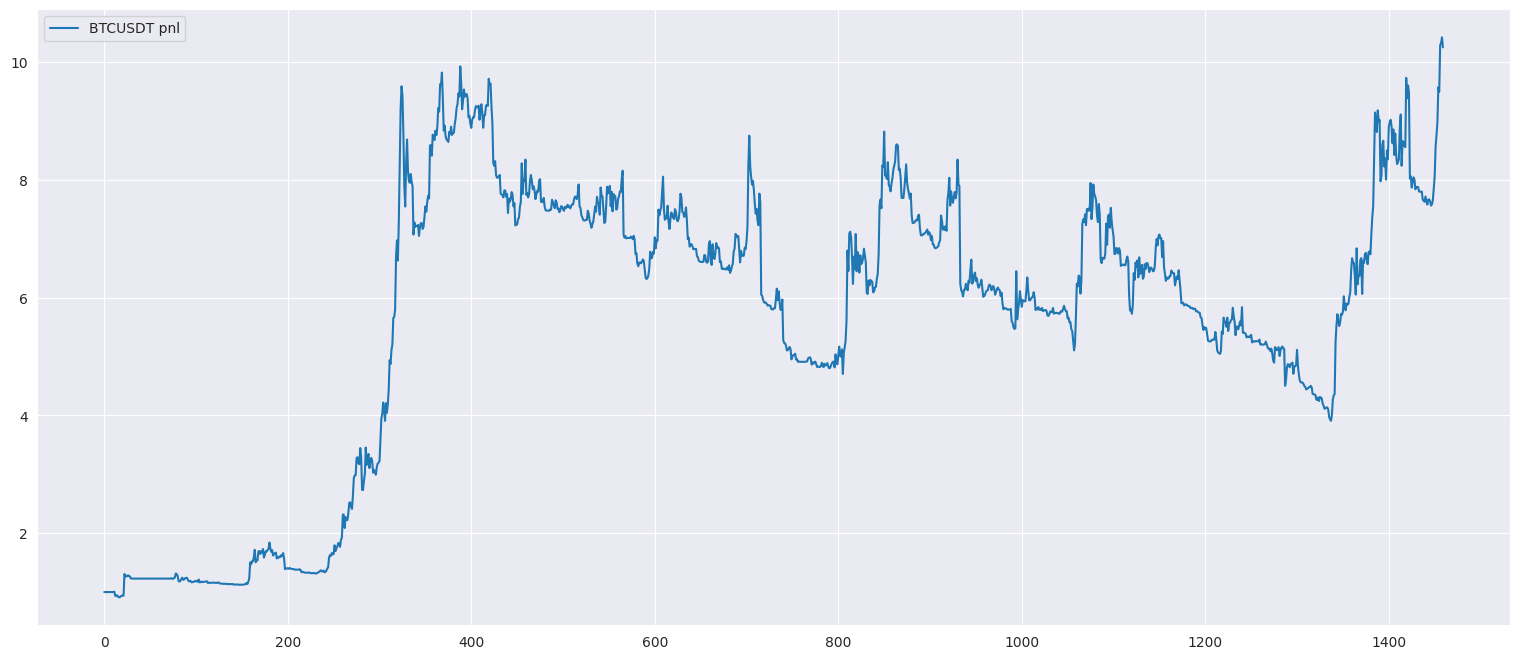

In [176]:
# TODO get an rsi strategy that works well
# TODO implement strategy weighting based on recent performance
# TODO implement manually adjustable weights for pairs / strats
# TODO implement other strats that work in different ways, look at ones i have collected on notion etc
# TODO when it's all working quite well, implement sequential forwards selection for portfolio construction

std_lb = 50
tau = 0.25
fees = 0.005 # 50bps should cover trading fees, spread and slippage
q = 0.2 # step size to round to
lens = (8, 16, 32, 64, 128)
timeframe = '1d'
annualiser = {'1h': 94, '4h': 47, '8h': 33, '1d': 19, '2d': 14, '3d': 11, '1w': 7}[timeframe]

results = {}

# all_pairs = [p.name.split('.')[0] for p in Path('/home/ross/coding/modular_trader/bin_ohlc_5m').glob('*')]
# my_pairs = all_pairs[3::10]
my_pairs = [
    'BTCUSDT', 
#     'ETHUSDT', 
#     'SOLUSDT', 
#     'LINKUSDT', 
#     'FXSUSDT',
#     'ROSEUSDT',
]

for pair in my_pairs:
    try:
        data = time_bars(pair, timeframe)
        # data = vol_bars(pair, 4_000)
    except pl.exceptions.ComputeError as e:
        print(pair)
        print(e)
        continue
    
    # if len(data) < 8760:
    #     continue
    
    data = dyn_risk_target(data, tau, std_lb, annualiser)
    
    # buy & hold with dynamic risk scaling
    data = data.with_columns(pl.col('dyn_risk_mult').alias('dyn_bnh_size'))
    data = data.with_columns(pl.col('dyn_bnh_size').truediv(q).round().mul(q).alias('final_dyn_size'))
    
    # ensemble of ema trend forecasts
    for l in lens:
        data = ma_cross_forecast(data, l, ema, 'ema')    
    data = data.with_columns(data.select(cs.contains('ema_diff')).mean_horizontal().alias('ema_size'))
    # TODO forecast diversification multiplier goes here
    data = standard_forecast(data, 'ema_size', flip=False)
    data = data.with_columns(pl.col('ema_size').mul('dyn_risk_mult').alias('ema_size')) # TODO try a/b testing with or without this line
    
    # rsi mean reversion
    rsi_len = 3
    data = rsi_forecast(data, rsi_len)
    # data = rsi_forecast(data, 32)
    # data = rsi_forecast(data, 64)
    # data = rsi_forecast(data, 128)
    
    # ichimoku strategies
    data = ichi_trend_forecast(data, 10, 30)
    
    # plt.figure(figsize=(19, 8))
    # sns.lineplot(data=data, x='timestamp', y=f'rsi_{rsi_len}_combined', label='rsi_forecast')
    # sns.lineplot(data=data, x='timestamp', y='ema_size')
    # sns.lineplot(data=data, x='timestamp', y='dyn_ema_size')
    # sns.lineplot(data=data, x='timestamp', y='final_ema_size')
    # plt.show()
    
    # TODO long term volatility regime
    
    crossfade = 0
    data = data.with_columns(
        (
            pl.col('ema_size')
            .mul(1 - crossfade)
            .add(
                pl.col('ichi_trend_10_30')
                .mul(crossfade)
            )
        ).alias('final_size')
    )
    
    # normalise avg size and quantise to reduce trading costs
    print(f"mean size: {data['final_size'].abs().mean()}")
    data = data.with_columns(pl.col('final_size').truediv(pl.col('final_size').abs().mean()).clip(lower_bound=-2, upper_bound=2).alias('final_size'))
    data = data.with_columns(pl.col('final_size').truediv(q).round().mul(q).alias('final_size'))
    print(f"mean size: {data['final_size'].abs().mean()}")

    results[f"{pair}_returns"] = data['pct_change']
    results[f"{pair}_size"] = data['final_size']
    results[f"{pair}_abs_size"] = data['final_size'].abs()
    
longest = 0
for l in results.values():
    longest = max(longest, len(l))

portfolio = pl.DataFrame()  
for k, v in results.items():
    portfolio = portfolio.with_columns(pl.Series([0.0] * (longest - len(v)), dtype=pl.Float64).extend(v).alias(k))

lev = 1

for c in my_pairs:
    portfolio = portfolio.with_columns(pl.col(f"{c}_size").mul(lev).truediv(pl.lit(len(my_pairs))).alias(f"{c}_size"), 
                                       pl.col(f"{c}_abs_size").mul(lev).truediv(pl.lit(len(my_pairs))).alias(f"{c}_abs_size"))

for pair in my_pairs:
    portfolio = size_to_pnl(portfolio, pair, fees)

portfolio = portfolio.with_columns(portfolio.select(cs.contains('pnl')).mean_horizontal().alias('total_pnl'))
portfolio = portfolio.with_columns(portfolio.select(cs.contains('abs_size')).sum_horizontal().alias('total_size'))

print(f"Max exposure: {portfolio['total_size'].max():.1f}x, Avg exposure: {portfolio['total_size'].mean():.1f}x")

portfolio = portfolio.with_columns(pl.col('total_pnl').cum_prod().fill_null(1.0).alias('port_pnl'))

perf_stats('portfolio', portfolio['port_pnl'], annualiser)

plt.figure(figsize=(19, 8))
t = f"{' '.join(my_pairs)} pnl" if len(my_pairs) <= 10 else f"{len(my_pairs)} pairs pnl"
sns.lineplot(data=portfolio['port_pnl'], label=t)
# sns.lineplot(data=portfolio['total_size'], label=f'exposure')
plt.show()

In [88]:
ha_df = time_bars('BTCUSDT', '8h')
ha_df = ichimoku(ha_df, 20, 60)

fig = go.Figure(data=[go.Candlestick(x=ha_df['timestamp'],
                open=ha_df['open'],
                high=ha_df['high'],
                low=ha_df['low'],
                close=ha_df['close'])])

# fig.add_trace(trace={'x': ha_df['timestamp'], 'y': ha_df['tenkan']})
# fig.add_trace(trace={'x': ha_df['timestamp'], 'y': ha_df['kijun']})
# fig.add_trace(trace={'x': ha_df['timestamp'], 'y': ha_df['chikou']})
fig.add_trace(trace={'x': ha_df['timestamp'], 'y': ha_df['senkou_a']})
fig.add_trace(trace={'x': ha_df['timestamp'], 'y': ha_df['senkou_b']})

fig.update_layout(
    height=800,
    width=1600,
    # xaxis_rangeslider_visible=False
)
fig.show()

shape: (1_461, 2)
┌────────────┬──────────────────┐
│ pct_change ┆ ichi_trend_score │
│ ---        ┆ ---              │
│ f64        ┆ f64              │
╞════════════╪══════════════════╡
│ 0.0        ┆ null             │
│ 0.001267   ┆ null             │
│ -0.021303  ┆ null             │
│ 0.04726    ┆ null             │
│ -0.056167  ┆ null             │
│ …          ┆ …                │
│ 0.013831   ┆ 1.0              │
│ 0.011461   ┆ 1.0              │
│ 0.033484   ┆ 1.0              │
│ -0.003996  ┆ 1.0              │
│ 0.043804   ┆ 1.0              │
└────────────┴──────────────────┘


<AxesSubplot: xlabel='timestamp', ylabel='ichi_pnl'>

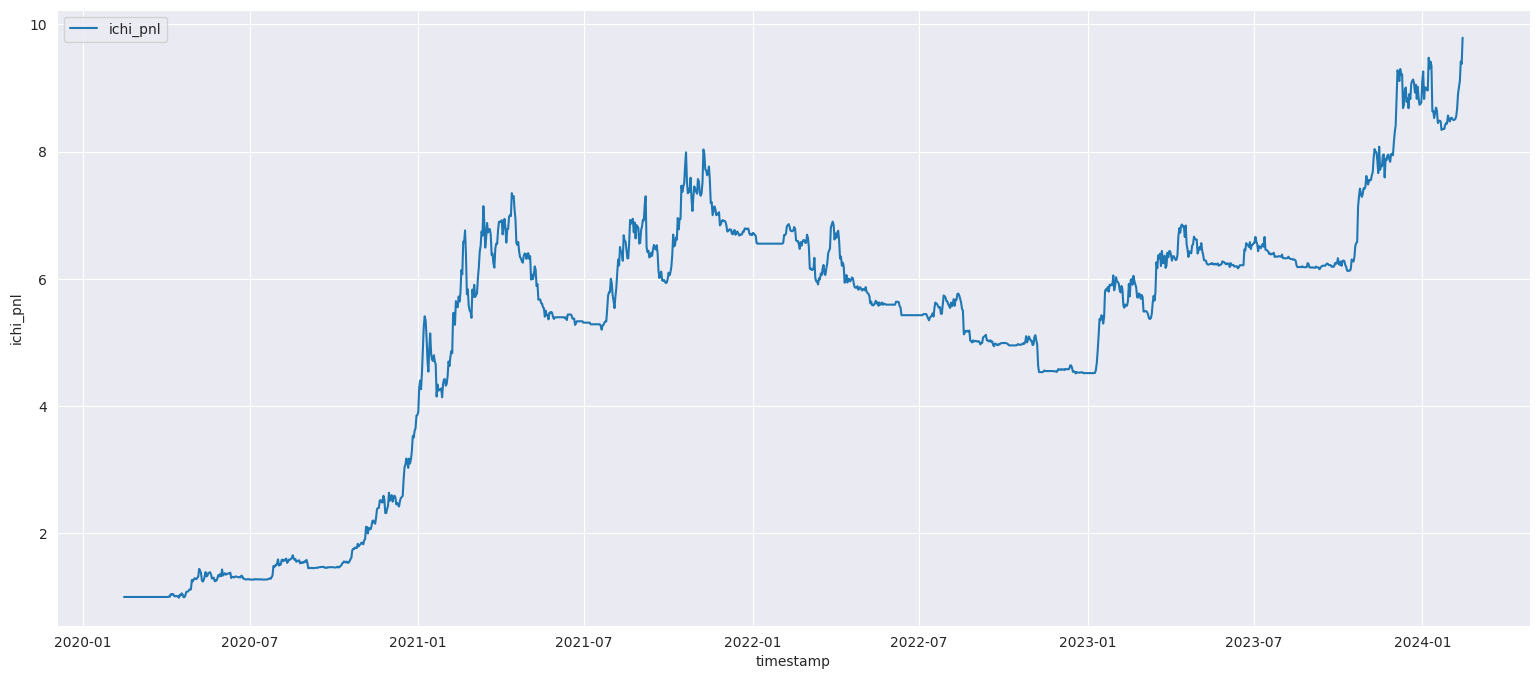

In [45]:
df = time_bars('BTCUSDT', '1d')
df = ichimoku(df, 10, 30)

df = df.with_columns(
    pl.col('pct_change').add(1).cum_prod().alias('cum_ret'),
    pl.col('pct_change').mul(pl.col('ichi_trend_score').shift()).fill_null(0).add(1).cum_prod().alias('ichi_pnl')
)

print(df.select(['pct_change', 'ichi_trend_score']))

plt.figure(figsize=(19, 8))
# sns.lineplot(data=df, x='timestamp', y='ichi_trend_score', label='ichi_trend_score')
# sns.lineplot(data=df, x='timestamp', y='cum_ret', label='pct_change')
sns.lineplot(data=df, x='timestamp', y='ichi_pnl', label='ichi_pnl')